# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import csv
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from fatiando import utils, mesher, inversion
from fatiando.gravmag import talwani

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\fatiando\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Inputs

In [2]:
# xz plane coordinate system, linear extent and depth of interest
area = (-100000, 300000, 40000, -1000)

# densities, each density corresponds to a polygon defined below, keep the order correct
title1 = 'Bouguer 1'
den1 = [{'density':0.0},   # crust
      {'density':-400.0},  # sediment
      {'density':-400.0},  # water
      {'density':400.0}]   # mantle

title2 = 'Bouguer 2'
den2 = [{'density':0.0},
      {'density':-600.0},
      {'density':0.0},
      {'density':400.0}]

title3 = 'Bouguer BCsed'
den3 = [{'density':0.0},
      {'density':-600.0},
      {'density':-600.0},
      {'density':400.0}]

title4 = 'Free Air'
den4 = [{'density':0.0},
      {'density':-600.0},
      {'density':-1770.0},
      {'density':400.0}]

# title5 = 'Free Air2'
# den5 = [{'density':0.0},
#       {'density':-600.0},
#       {'density':-1770.0},
#       {'density':400.0}]
# different polygons

# title6 = 'Free Air No Canyon'
# den6 = [{'density':0.0},
#       {'density':-600.0},
#       {'density':-1770.0},
#       {'density':400.0}]
# different polygons

# crust polygon
Cpoly = [(-1000000.0,0.0),
        (0.0,0.0),
        (30000.0,5000.0),
        (70000.0,5000.0),
        (100000.0,3000.0),
        (200000.0,3000.0),
        (210000.0,1000.0),
        (240000.0,1000.0),
        (250000.0,3000.0),
        (1000000.0,3000.0),
        (1000000.0,14000.0),
        (100000.0,14000.0),
        (70000.0,16000.0),
        (30000.0,16000.0),
        (0.0,35000.0),
        (-1000000.0,35000.0)]


# sediment polygon
Spoly = [[0.0,0.0],
        [50000.0,0.0],
        [60000.0,2000.0],
        [70000.0,0.0],
        [100000.0,3000.0],
        [70000.0,5000.0],
        [30000.0,5000.0]]


# water polygon
Wpoly = [[50000.0,0.0],
        [1000000.0,0.0],
        [1000000.0,3000.0],
        [250000.0,3000.0],
        [240000.0,1000.0],
        [210000.0,1000.0],
        [200000.0,3000.0],
        [100000.0,3000.0],
        [70000.0,10.0],
        [60000.0,2000.0]]


# mantle polygon
Mpoly = [[0.0,35000.0],
        [30000.0,16000.0],
        [70000.0,16000.0],
        [100000.0,14000.0],
        [1000000.0,14000.0],
        [1000000.0,35000.0]]

shapes = [Cpoly,Spoly,Wpoly,Mpoly]
scenario_Bouguer = [title1, shapes, den1]

import pickle
export_Scenario = {'crust': Cpoly, 'sediment':Spoly, 'water':Wpoly, 'mantle':Mpoly}
outputpath = 'FromDUG/ronspolys.pkl'
f = open(outputpath, 'wb')
pickle.dump(export_Scenario,f)
f.close()

# Cden = {'density':0.0}
# Sden = {'density':-400.0}
# Wden = {'density':-400.0}
# Mden = {'density':400.0}

# Defining Gravity Forward Model Calculation

In [3]:
def talwaniCalc(shapes,densities):
    """
    performs the gravity forward model calculation according to
    Talwani et al.'s method as implemented by Fatiando
    
    Takes an array of polygon coordinates (as an array of [X,Y] points)
    and an array of dicts of the same length, each dict having the key
    'density', and the value of the density for the corresponding polygon
    (by index number) in kgm^-3
    """
    if len(shapes) > len(densities):          # dummy checking
        return ("One of your polygons is missing a density - check your inputs")
    elif len(shapes) < len(densities):
        return("You have more density values than polygons - check your inputs")
    PolyDens = []
    for i in range(len(shapes)):
        PolyDens.append(mesher.Polygon(shapes[i],densities[i]))

    xp = np.arange(-100000.0, 300000.0, 5000.0) # define measurement points and compute gravity
    zp = np.zeros_like(xp)
    gz = talwani.gz(xp, zp, PolyDens)
    model = pd.DataFrame({'xp': xp, 'gz':gz})
    return model

# Drawing the Charts

In [4]:
# scenario is an array with a title, array of polygon coordinates, and array of density dicts
def drawAll(scenario):
    plottitle = scenario[0]
    polys = scenario[1]
    densities = scenario[2]

    NPpolys = []
    for polygon in polys:
        NPpolys.append(Polygon(np.array(polygon),True))
    # generate patches
    p = PatchCollection(NPpolys,cmap=matplotlib.cm.jet, alpha = 0.4)

    # generate a range of random colours
    # works for up to 99 different polygons
    # colours could be manually fixed if desired, something to ponder
    colours = np.empty(len(polys))
    for i in range(len(polys)):
        if i < 10:
            colours[i] = int(colours[i] * 100)
        else:
            colours[i] = int((colours[i] * 10) + 5)
    p.set_array(colours)

    model = talwaniCalc(shapes, densities)

    area = [-100000,300000,0,35000] 
    plt.subplot(211)
    plt.title(plottitle)
    plt.axis(area)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m below sea level)')
    plt.gca().add_collection(p)
    # the locations for these labels need to be created manually
    plt.text(-90000,10000, 'p =' + str(densities[0]['density']))
    plt.text(0,5000, 'p =' + str(densities[1]['density']))
    plt.text(100000,5000, 'p =' + str(densities[2]['density']))
    plt.text(100000,25000, 'p =' + str(densities[3]['density']))

    plt.subplot(212)
    plt.axis([-100000,300000,0,400])
    plt.plot(model['xp'], model['gz'], 'k')
    plt.ylabel('Anomaly (mGal)')
    plt.show()

#     polys = [Polygon(np.array(Cpoly),True),
#     Polygon(np.array(Spoly),True),
#     Polygon(np.array(Wpoly),True),
#     Polygon(np.array(Mpoly),True)]
#     p.set_array(np.array([100,200,300,400]))

# Running It

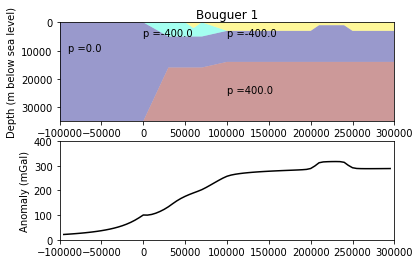

In [6]:
drawAll(scenario_Bouguer)